In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)

df = pd.DataFrame(data)

Saving data_balita.xlsx to data_balita.xlsx


# **1. memuat data, mengecek apakah ada data yang kosong, & menanganinya**

In [ ]:
df = pd.read_excel('data_balita.xlsx')

# mengecek apakah ada data yang kosong
print(df.isnull().sum(),'\n')

print(df[df.isnull().any(axis=1)],'\n')
scaler = MinMaxScaler()

# menampilkan nilai status gizi yang paling sering muncul
most_frequent_status_gizi = df['Status Gizi'].mode()[0]
df.fillna({'Status Gizi': most_frequent_status_gizi}, inplace=True)

# melakukan pengecekan ulang
print(df.isnull().sum(),'\n')

print(df.head())

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          1
dtype: int64 

    Umur (bulan) Jenis Kelamin  Tinggi Badan (cm) Status Gizi
45             0     laki-laki       5.941116e+14         NaN 

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64 

   Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0             0     laki-laki       4.459197e+14           stunted
1             0     laki-laki       5.670520e+14            tinggi
2             0     laki-laki       4.686336e+14            normal
3             0     laki-laki       4.750803e+14            normal
4             0     laki-laki       4.274349e+14  severely stunted


# **2. memperbaiki kolom yang tidak realistis pada data**

In [ ]:
# nilai tinggi badan diatur antara 45 sampai 120, dan selain itu akan diberikan nilai NaN
df['Tinggi Badan (cm)'] = df['Tinggi Badan (cm)'].apply(
    lambda x: x if 45 <= x <= 120 else np.nan
)

print(df.isnull().sum(),'\n')

# mengubah tinggi badan dalam bentuk numerik
df['Tinggi Badan (cm)'] = pd.to_numeric(df['Tinggi Badan (cm)'], errors='coerce')
mean_tinggi_badan = df['Tinggi Badan (cm)'].mean()

# mengisi kekosongan tinggi badan yang kosong
df.fillna({'Tinggi Badan (cm)': mean_tinggi_badan}, inplace=True)
print('\n')

print(df)

Umur (bulan)            0
Jenis Kelamin           0
Tinggi Badan (cm)    8550
Status Gizi             0
dtype: int64 



        Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0                  0     laki-laki          89.649101           stunted
1                  0     laki-laki          89.649101            tinggi
2                  0     laki-laki          89.649101            normal
3                  0     laki-laki          89.649101            normal
4                  0     laki-laki          89.649101  severely stunted
...              ...           ...                ...               ...
120994            60     perempuan         100.600000            normal
120995            60     perempuan          98.300000           stunted
120996            60     perempuan          89.649101            normal
120997            60     perempuan         112.200000            normal
120998            60     perempuan         109.800000            normal

[120999 rows x

# **3. normalisasi**

In [ ]:
df['Tinggi Badan (cm)'] = scaler.fit_transform(df[['Tinggi Badan (cm)']]).round(2)
print(df)

        Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0                  0     laki-laki               0.58           stunted
1                  0     laki-laki               0.58            tinggi
2                  0     laki-laki               0.58            normal
3                  0     laki-laki               0.58            normal
4                  0     laki-laki               0.58  severely stunted
...              ...           ...                ...               ...
120994            60     perempuan               0.73            normal
120995            60     perempuan               0.70           stunted
120996            60     perempuan               0.58            normal
120997            60     perempuan               0.89            normal
120998            60     perempuan               0.86            normal

[120999 rows x 4 columns]


# **4. melatih model Logistic Regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

df = spark.createDataFrame(df)

# mengubah kolom kategori menjadi angka
indexer = StringIndexer(inputCol="Status Gizi", outputCol="StatusGiziIndex")
df = indexer.fit(df).transform(df)

# mempersiapkan data untuk pemodelan
assembler = VectorAssembler(inputCols=['Tinggi Badan (cm)'], outputCol='Features')
df_transformed = assembler.transform(df)

# membagi data menjadi set pelatihan dan pengujian
train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)

# melatih model Logistic Regression
lr = LogisticRegression(featuresCol='Features', labelCol='StatusGiziIndex')
model = lr.fit(df_transformed)

# **5. hyperparameter tuning menggunakan cross-validation**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Membuat grid parameter untuk hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol='StatusGiziIndex', metricName='accuracy')

# Membuat CrossValidator
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Melakukan cross-validation dan memilih model terbaik
cvModel = crossval.fit(train_df)

# Memprediksi dan mengevaluasi model terbaik
predictions = cvModel.transform(test_df)
accuracy = evaluator.evaluate(predictions)
print(f'Akurasi: {accuracy}')

# Menampilkan parameter terbaik
bestModel = cvModel.bestModel
print(f'Best regParam: {bestModel._java_obj.getRegParam()}')
print(f'Best elasticNetParam: {bestModel._java_obj.getElasticNetParam()}')

Akurasi: 0.5792426367461431
Best regParam: 0.1
Best elasticNetParam: 0.5


# **6. mendapatkan label asli untuk representasi kelas**

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Status Gizi", outputCol="Status_Gizi_Index")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)

# mendapatkan label asli
status_gizi_labels = indexer_model.labels
print(status_gizi_labels)

['normal', 'severely stunted', 'tinggi', 'stunted']


# **7. mengukur kinerja dari model klasifikasi**

              Class     TP     FP    FN     TN
0            normal  13430  10011    90    711
1  severely stunted    612    189  3433  20008
2            tinggi      0      0  3926  20316
3           stunted      0      0  2751  21491


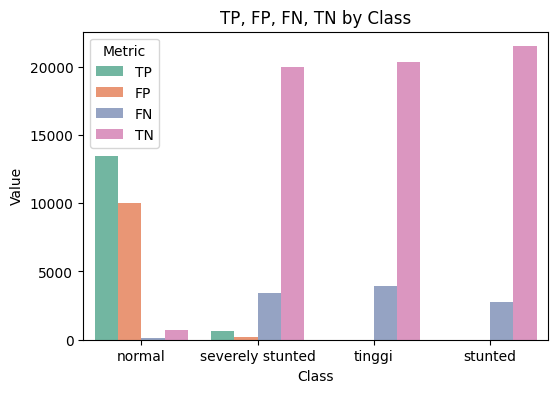

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

predictions_pd = predictions.select('StatusGiziIndex', 'prediction').toPandas()

# Membuat confusion matrix
cm = confusion_matrix(predictions_pd['StatusGiziIndex'], predictions_pd['prediction'], labels=range(len(status_gizi_labels)))

TP = cm.diagonal()
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

# Menampilkan hasil
result = pd.DataFrame({
    "Class": status_gizi_labels,
    "TP": TP,
    "FP": FP,
    "FN": FN,
    "TN": TN
})
print(result)
# Visualisasi hasil TP, FP, FN, TN
result = result.melt(id_vars="Class", var_name="Metric", value_name="Value")
plt.figure(figsize=(6, 4))
sns.barplot(x="Class", y="Value", hue="Metric", data=result, palette="Set2")
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('TP, FP, FN, TN by Class')
plt.show()